In [224]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

In [225]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [3]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3

changed = [10110, 11110, 11310, 12510, 13510, 20910, 21110, 22510, 23510, 30110, 30910,
32510, 33510, 40110, 40910, 41110, 42510, 42710, 51110, 52510, 53510, 60110,
61110, 62510, 63510]

In [4]:
def find_pipe_edges(line, pipe_data):
    tt = line.get_table()

    #pipe names
    pipe_names = list(pipe_data.keys())
    apers_to_add = {}
    
    for pipe_name in pipe_names:
        if 'edge_names' in pipe_data[pipe_name]:
            assert pipe_data[pipe_name]['edge_names'][0] in tt.name and pipe_data[pipe_name]['edge_names'][1] in tt.name, f"Pipe edge names {pipe_data[pipe_name]['edge_names']} not found in line for {pipe_name}"
        
        else:
            assert 'edge_positions' in pipe_data[pipe_name], f"Please provide edge names or edge positions for {pipe_name}"

            #Looking if apertures already exist in line
            pipe_start = None
            pipe_end = None
            for nn in tt.rows[(tt.s > pipe_data[pipe_name]['edge_positions'][0] - 1e-3 ) & (tt.s < pipe_data[pipe_name]['edge_positions'][0] + 1e-2 )].name:
                if line[nn].__class__.__name__.startswith('Limit'):
                    pipe_start = nn

            for nn in tt.rows[(tt.s > pipe_data[pipe_name]['edge_positions'][-1] - 1e-3 ) & (tt.s < pipe_data[pipe_name]['edge_positions'][-1] + 1e-2 )].name:
                if line[nn].__class__.__name__.startswith('Limit'):
                    pipe_end = nn
                    break
            
            if pipe_start is None or pipe_end is None:
                apers_to_add[pipe_name] = {'positions': pipe_data[pipe_name]['edge_positions'],
                                           'names': [f'{pipe_name}.a_aper', f'{pipe_name}.b_aper']}
                pipe_data[pipe_name]['edge_names'] = [f'{pipe_name}.a_aper', f'{pipe_name}.b_aper']
            else:
                pipe_data[pipe_name]['edge_names'] = [pipe_start, pipe_end]

    if len(list(apers_to_add.keys()))>0:
        insertions = []
        for pipe_name in apers_to_add.keys():
            line.env.elements[apers_to_add[pipe_name]['names'][0]] = pipe_data[pipe_name]['apertures'][0].copy()
            line.env.elements[apers_to_add[pipe_name]['names'][1]] = pipe_data[pipe_name]['apertures'][-1].copy()

        insertions += [line.env.place(apers_to_add[pipe_name]['names'][0], at=apers_to_add[pipe_name]['positions'][0]),
                        line.env.place(apers_to_add[pipe_name]['names'][1], at=apers_to_add[pipe_name]['positions'][1])]

        line.insert(insertions, s_tol=1e-6)

    return pipe_data

In [5]:
def get_slicing_strategies(line, pipe_data):
    slicing_strategies = [xt.Strategy(slicing=None)]
    pipe_names = list(pipe_data.keys())
    tt = line.get_table()

    active_elements = []
    # Finding active elements in the pipe
    for pipe_name in pipe_names:
        pipe_start, pipe_end = pipe_data[pipe_name]['edge_names']
        for nn, ee in zip(tt.rows[f'{pipe_start}>>1':pipe_end].name, tt.rows[f'{pipe_start}>>1':pipe_end].element_type):
            if ee.startswith('Drift') or ee.startswith('Marker') or ee.startswith('Limit'):
                continue
            else:
                active_elements.append(nn)
    
    for nn in active_elements:
        slicing_strategies.append(xt.Strategy(slicing=xt.Teapot(5), name=nn))
    return slicing_strategies

In [209]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt1 = line.get_table()
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()


pipe_data = {}

for nn in changed:
    flange_number = nn-9
    pipe_name = f'vcak.{flange_number}'
    
    L3 = line.get_s_position(f'vcak.{flange_number}.b_aper') - line.get_s_position(f'vcak.{flange_number}.a_aper') - L1 - L2
    if L3 < 0:
        raise ValueError(f'Pipe {pipe_name} too short to fit all apertures, please adjust L1 and L2')
    
    pipe_data[pipe_name] = {'apertures': [xt.LimitEllipse(a=r1, b=r1, shift_x=-5.3e-3), 
                                  xt.LimitEllipse(a=r2, b=r2, shift_x=-5.3e-3),
                                  xt.LimitEllipse(a=r3, b=r3)],
                            'lengths': [L1, L2, L3],
                            #'edge_names': [f'{pipe_name}.a_aper', f'{pipe_name}.b_aper'],
                            'edge_positions': [line.get_s_position(f'vcak.{flange_number}.a_aper'), line.get_s_position(f'vcak.{flange_number}.b_aper')]
                            }
    

pipe_data = find_pipe_edges(line, pipe_data)

slicing_strategies = get_slicing_strategies(line, pipe_data)
line.slice_thick_elements(slicing_strategies)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
The line already has an associated tracker


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

{'sps$start': ['sps$start'],
 'begi.10010': ['begi.10010'],
 'qf.10010': ['qf.10010'],
 'drift_0..0': ['drift_0..0'],
 'veqf.10010.b_aper': ['veqf.10010.b_aper'],
 'drift_0..1': ['drift_0..1'],
 'veba.10030.a_aper': ['veba.10030.a_aper'],
 'drift_0..2': ['drift_0..2'],
 'mba.10030_entry': ['mba.10030_entry'],
 'mba.10030..entry_map': ['mba.10030..entry_map'],
 'mba.10030..0_aper2': ['mba.10030..0_aper2'],
 'mba.10030..0': ['mba.10030..0'],
 'mba.10030..1_aper2': ['mba.10030..1_aper2'],
 'mba.10030..1': ['mba.10030..1'],
 'mba.10030..2_aper2': ['mba.10030..2_aper2'],
 'mba.10030..2': ['mba.10030..2'],
 'mba.10030..3_aper2': ['mba.10030..3_aper2'],
 'mba.10030..3': ['mba.10030..3'],
 'mba.10030..4_aper2': ['mba.10030..4_aper2'],
 'mba.10030..4': ['mba.10030..4'],
 'mba.10030..5_aper2': ['mba.10030..5_aper2'],
 'mba.10030..5': ['mba.10030..5'],
 'mba.10030..6_aper2': ['mba.10030..6_aper2'],
 'mba.10030..6': ['mba.10030..6'],
 'mba.10030..7_aper2': ['mba.10030..7_aper2'],
 'mba.10030..7': 

In [210]:
tt = line.get_table()

#For testing, to put in a loop later
pipe_name = 'vcak.13501'
pipe_start, pipe_end = pipe_data[pipe_name]['edge_names']
prev_nn, prev_ee = None, None

insertions = []
for i, (l, aper) in enumerate(zip(pipe_data[pipe_name]['lengths'], pipe_data[pipe_name]['apertures'])):
    start_s_coll = line.get_s_position(pipe_start) + sum(pipe_data[pipe_name]['lengths'][:pipe_data[pipe_name]['lengths'].index(l)])
    end_s_coll = start_s_coll + l
    coll_base_name = f'{pipe_name}_coll_{pipe_data[pipe_name]["lengths"].index(l)}'

    print(l, end_s_coll - start_s_coll)

    names = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].name) if prev_nn is None else [prev_nn] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].name)
    elements = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].element_type) if prev_ee is None else [prev_ee] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].element_type)

    if end_s_coll < tt.rows[names[-1]].s_end: prev_nn, prev_ee = names[-1], elements[-1]
    else: prev_nn, prev_ee = None, None
    print(start_s_coll, end_s_coll, names, elements)

    #Defining jaws from aperture
    if aper.__class__.__name__ == 'LimitEllipse':
        jaw_L = aper.a - aper.shift_x
        jaw_R = -aper.a - aper.shift_x
    else:
        jaw_L = aper.max_x - aper.shift_x
        jaw_R = aper.min_x - aper.shift_x
    
    #Creating collimators
    coll_length = 0
    coll_elems = []
    counter = 0
    ActiveElementEncountered = False

    for nn, ee in zip(names, elements):
        
        if ee.startswith('Limit'):
            if nn == pipe_start:
                ref_element = nn
                continue
            else:
                coll_elems.append(nn)

        elif ee.startswith('Marker') or ee.startswith('Drift'):
            coll_elems.append(nn)
            if hasattr(line.env.elements[nn], 'length'):
                drift_length = line.env.elements[nn].length
                    #ref_element = prev_coll
                #coll_length += line.env.elements[nn].length
            elif hasattr(line.env.elements[nn], '_parent'):
                drift_length = line.env.elements[nn]._parent.length * line.env.elements[nn].weight
                #coll_length += line.env.elements[nn]._parent.length * line.env.elements[nn].weight
            else:
                drift_length = 0
            
            if ee.startswith('Drift') and nn == names[0]:
                drift_length -= line.env.elements[prev_coll].length

            # if ee.startswith('Drift') and nn == names[0]:
            #     ref_element = prev_coll

            if coll_length + drift_length > l:
                print('break')
                ActiveElementEncountered = False
                break
            else:
                coll_length += drift_length
        else:
        
            ActiveElementEncountered = True

            # assert coll_length <=l, f'Collimator length {coll_length} exceeds pipe segment length {l} in {pipe_name}'
        
            print(i, 'active element encountered:', nn)
            print(coll_length, line.get_s_position(nn)-line.get_s_position(coll_elems[0]))
            print(ref_element)
            line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=coll_length, material=xc.materials.Glidcop, jaw_L=jaw_L, jaw_R=jaw_R)
            insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
            #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{nn}@start', anchor='end'))
            

            coll_length = 0
            coll_elems = []
            ref_element = nn
            counter += 1
    if not ActiveElementEncountered:
        line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=l, material=xc.materials.Glidcop, jaw_L=jaw_L, jaw_R=jaw_R)
        #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=start_s_coll))
        insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
        ref_element = f'{coll_base_name}..{counter}' # place based on previous collimator
        prev_coll = f'{coll_base_name}..{counter}'
        print(i, 'No active element encountered')

    elif elements[-1].startswith('Limit') or elements[-1].startswith('Marker') or elements[-1].startswith('Drift'):
        ref_element = f'{coll_base_name}..{counter-1}' # place based on previous collimator
        print(i, 'New ref element:', ref_element)

    # if i == 1:
    #     break
    
line.insert(insertions, s_tol=1e-6)

0.034 0.0340000000001055
1117.7732 1117.8072000000002 ['vcak.13501.a_aper', 'drift_299..2'] ['LimitEllipse', 'DriftSlice']
break
0 No active element encountered
0.07 0.06999999999993634
1117.8072000000002 1117.8772000000001 ['drift_299..2', 'lod.13502_entry', 'lod.13502..entry_map', 'drift_lod.13502..0'] ['DriftSlice', 'Marker', 'ThinSliceOctupoleEntry', 'DriftSliceOctupole']
1 active element encountered: lod.13502..entry_map
0.06819999999799255 0.10219999999799256
vcak.13501_coll_0..0
1 New ref element: vcak.13501_coll_1..0
0.7547999999997463 0.7547999999997046
1117.8772000000001 1118.6319999999998 ['drift_lod.13502..0', 'lod.13502..0', 'drift_lod.13502..1', 'lod.13502..1', 'drift_lod.13502..2', 'lod.13502..2', 'drift_lod.13502..3', 'lod.13502..3', 'drift_lod.13502..4', 'lod.13502..4', 'drift_lod.13502..5', 'lod.13502..exit_map', 'lod.13502_exit', 'drift_300..0'] ['DriftSliceOctupole', 'ThinSliceOctupole', 'DriftSliceOctupole', 'ThinSliceOctupole', 'DriftSliceOctupole', 'ThinSliceOctu

Slicing line:   0%|          | 0/32330 [00:00<?, ?it/s]

In [211]:
tt = line.get_table()

In [202]:
insertions

[Place(vcak.13501_coll_0..0, at=0, from_=vcak.13501.a_aper, anchor=start, from_anchor=end),
 Place(vcak.13501_coll_1..0, at=0, from_=vcak.13501_coll_0..0, anchor=start, from_anchor=end)]

In [160]:
L2

0.07

In [158]:
line['vcak.13501_coll_1..0']

View of EverestCollimator(length=0.102, active=np.int8(1), _record_interactions=np.int8(0), _internal_record_id=RecordIdentifier(buffer_id=np.int64(0), offset=np.int64(0)), _sin_zL=0, _cos_zL=1, _sin_zR=0, _cos_zR=1, _sin_zDiff=0, _cos_zDiff=1, _jaws_parallel=np.int8(1), _jaw_LU=0.0638, _jaw_RU=-0.0532, _jaw_LD=0.0638, _jaw_RD=-0.0532, _sin_yL=0, _cos_yL=1, _tan_yL=0, _sin_yR=0, _cos_yR=1, _tan_yR=0, _side=np.int8(0), _align=np.int8(0), _gap_L=999, _gap_R=-999, _nemitt_x=0, _nemitt_y=0, _material=Material(Z=28.8, A=63.1, density=8.93, excitation_energy=3.21e-07, nuclear_radius=0.418, nuclear_elastic_slope=209, cross_section=array([1.246  , 0.765  , 0.     , 0.     , 0.     , 0.00139]), hcut=0.02, name='Glidcop', _only_mcs=np.int8(0), radiation_length=0.0144), rutherford_rng=RandomRutherford(lower_val=0.000998, upper_val=0.02, A=0.00156, B=150, Newton_iterations=np.int8(7), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _rot_x_rad=0, _rot_y_rad=0, _rot_s_rad_no_fr

In [186]:
tt.rows['vcak.13501.a_aper':'vcak.13501.b_aper']

Table: 19 rows, 11 cols
name                             s element_type           isthick isreplica parent_name ...
vcak.13501.a_aper          1117.77 LimitEllipse             False     False None       
drift_299..2               1117.77 DriftSlice                True     False drift_299  
lod.13502_entry            1117.88 Marker                   False     False None       
lod.13502..entry_map       1117.88 ThinSliceOctupoleEntry   False     False lod.13502  
drift_lod.13502..0         1117.88 DriftSliceOctupole        True     False lod.13502  
lod.13502..0               1117.93 ThinSliceOctupole        False     False lod.13502  
drift_lod.13502..1         1117.93 DriftSliceOctupole        True     False lod.13502  
lod.13502..1               1118.07 ThinSliceOctupole        False     False lod.13502  
drift_lod.13502..2         1118.07 DriftSliceOctupole        True     False lod.13502  
lod.13502..2               1118.21 ThinSliceOctupole        False     False lod.13502  
drif

In [212]:
tt.rows['vcak.13501.a_aper':'vcak.13501.b_aper']

Table: 21 rows, 11 cols
name                              s element_type           isthick isreplica parent_name ...
vcak.13501.a_aper           1117.77 LimitEllipse             False     False None       
vcak.13501_coll_0..0        1117.77 EverestCollimator         True     False None       
vcak.13501_coll_1..0        1117.81 EverestCollimator         True     False None       
lod.13502_entry             1117.88 Marker                   False     False None       
lod.13502..entry_map        1117.88 ThinSliceOctupoleEntry   False     False lod.13502  
vcak.13501_coll_2..0        1117.88 EverestCollimator         True     False None       
drift_lod.13502..0..1        1117.9 DriftSliceOctupole        True     False lod.13502  
lod.13502..0                1117.93 ThinSliceOctupole        False     False lod.13502  
vcak.13501_coll_2..1        1117.93 EverestCollimator         True     False None       
lod.13502..1                1118.07 ThinSliceOctupole        False     False lod.1

In [204]:
line['vcak.13501_coll_1..0']

View of EverestCollimator(length=0.07, active=np.int8(1), _record_interactions=np.int8(0), _internal_record_id=RecordIdentifier(buffer_id=np.int64(0), offset=np.int64(0)), _sin_zL=0, _cos_zL=1, _sin_zR=0, _cos_zR=1, _sin_zDiff=0, _cos_zDiff=1, _jaws_parallel=np.int8(1), _jaw_LU=0.0638, _jaw_RU=-0.0532, _jaw_LD=0.0638, _jaw_RD=-0.0532, _sin_yL=0, _cos_yL=1, _tan_yL=0, _sin_yR=0, _cos_yR=1, _tan_yR=0, _side=np.int8(0), _align=np.int8(0), _gap_L=999, _gap_R=-999, _nemitt_x=0, _nemitt_y=0, _material=Material(Z=28.8, A=63.1, density=8.93, excitation_energy=3.21e-07, nuclear_radius=0.418, nuclear_elastic_slope=209, cross_section=array([1.246  , 0.765  , 0.     , 0.     , 0.     , 0.00139]), hcut=0.02, name='Glidcop', _only_mcs=np.int8(0), radiation_length=0.0144), rutherford_rng=RandomRutherford(lower_val=0.000998, upper_val=0.02, A=0.00156, B=150, Newton_iterations=np.int8(7), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _rot_x_rad=0, _rot_y_rad=0, _rot_s_rad_no_fra

In [172]:
line['vcak.13501_coll_1..0']

View of EverestCollimator(length=0.07, active=np.int8(1), _record_interactions=np.int8(0), _internal_record_id=RecordIdentifier(buffer_id=np.int64(0), offset=np.int64(0)), _sin_zL=0, _cos_zL=1, _sin_zR=0, _cos_zR=1, _sin_zDiff=0, _cos_zDiff=1, _jaws_parallel=np.int8(1), _jaw_LU=0.0638, _jaw_RU=-0.0532, _jaw_LD=0.0638, _jaw_RD=-0.0532, _sin_yL=0, _cos_yL=1, _tan_yL=0, _sin_yR=0, _cos_yR=1, _tan_yR=0, _side=np.int8(0), _align=np.int8(0), _gap_L=999, _gap_R=-999, _nemitt_x=0, _nemitt_y=0, _material=Material(Z=28.8, A=63.1, density=8.93, excitation_energy=3.21e-07, nuclear_radius=0.418, nuclear_elastic_slope=209, cross_section=array([1.246  , 0.765  , 0.     , 0.     , 0.     , 0.00139]), hcut=0.02, name='Glidcop', _only_mcs=np.int8(0), radiation_length=0.0144), rutherford_rng=RandomRutherford(lower_val=0.000998, upper_val=0.02, A=0.00156, B=150, Newton_iterations=np.int8(7), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _rot_x_rad=0, _rot_y_rad=0, _rot_s_rad_no_fra

In [81]:
tt= line.get_table()

In [99]:
coll_elems

['drift_lod.13502..0']

# Function

In [213]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt1 = line.get_table()
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()


pipe_data = {}

for nn in changed:
    flange_number = nn-9
    pipe_name = f'vcak.{flange_number}'
    
    L3 = line.get_s_position(f'vcak.{flange_number}.b_aper') - line.get_s_position(f'vcak.{flange_number}.a_aper') - L1 - L2
    if L3 < 0:
        raise ValueError(f'Pipe {pipe_name} too short to fit all apertures, please adjust L1 and L2')
    
    pipe_data[pipe_name] = {'apertures': [xt.LimitEllipse(a=r1, b=r1, shift_x=-5.3e-3), 
                                  xt.LimitEllipse(a=r2, b=r2, shift_x=-5.3e-3),
                                  xt.LimitEllipse(a=r3, b=r3)],
                            'lengths': [L1, L2, L3],
                            #'edge_names': [f'{pipe_name}.a_aper', f'{pipe_name}.b_aper'],
                            'edge_positions': [line.get_s_position(f'vcak.{flange_number}.a_aper'), line.get_s_position(f'vcak.{flange_number}.b_aper')]
                            }
    

pipe_data = find_pipe_edges(line, pipe_data)

slicing_strategies = get_slicing_strategies(line, pipe_data)
line.slice_thick_elements(slicing_strategies)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
The line already has an associated tracker


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

{'sps$start': ['sps$start'],
 'begi.10010': ['begi.10010'],
 'qf.10010': ['qf.10010'],
 'drift_0..0': ['drift_0..0'],
 'veqf.10010.b_aper': ['veqf.10010.b_aper'],
 'drift_0..1': ['drift_0..1'],
 'veba.10030.a_aper': ['veba.10030.a_aper'],
 'drift_0..2': ['drift_0..2'],
 'mba.10030_entry': ['mba.10030_entry'],
 'mba.10030..entry_map': ['mba.10030..entry_map'],
 'mba.10030..0_aper2': ['mba.10030..0_aper2'],
 'mba.10030..0': ['mba.10030..0'],
 'mba.10030..1_aper2': ['mba.10030..1_aper2'],
 'mba.10030..1': ['mba.10030..1'],
 'mba.10030..2_aper2': ['mba.10030..2_aper2'],
 'mba.10030..2': ['mba.10030..2'],
 'mba.10030..3_aper2': ['mba.10030..3_aper2'],
 'mba.10030..3': ['mba.10030..3'],
 'mba.10030..4_aper2': ['mba.10030..4_aper2'],
 'mba.10030..4': ['mba.10030..4'],
 'mba.10030..5_aper2': ['mba.10030..5_aper2'],
 'mba.10030..5': ['mba.10030..5'],
 'mba.10030..6_aper2': ['mba.10030..6_aper2'],
 'mba.10030..6': ['mba.10030..6'],
 'mba.10030..7_aper2': ['mba.10030..7_aper2'],
 'mba.10030..7': 

In [214]:
pipe_names = list(pipe_data.keys())
tt = line.get_table()
insertions = []

for pipe_name in pipe_names:
    pipe_start, pipe_end = pipe_data[pipe_name]['edge_names']
    prev_nn, prev_ee = None, None

    for i, (l, aper) in enumerate(zip(pipe_data[pipe_name]['lengths'], pipe_data[pipe_name]['apertures'])):
        start_s_coll = line.get_s_position(pipe_start) + sum(pipe_data[pipe_name]['lengths'][:pipe_data[pipe_name]['lengths'].index(l)])
        end_s_coll = start_s_coll + l
        coll_base_name = f'{pipe_name}_coll_{pipe_data[pipe_name]["lengths"].index(l)}'

        print(l, end_s_coll - start_s_coll)

        names = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].name) if prev_nn is None else [prev_nn] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].name)
        elements = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].element_type) if prev_ee is None else [prev_ee] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].element_type)

        if end_s_coll < tt.rows[names[-1]].s_end: prev_nn, prev_ee = names[-1], elements[-1]
        else: prev_nn, prev_ee = None, None
        print(start_s_coll, end_s_coll, names, elements)

        #Defining jaws from aperture
        if aper.__class__.__name__ == 'LimitEllipse':
            jaw_L = aper.a - aper.shift_x
            jaw_R = -aper.a - aper.shift_x
        else:
            jaw_L = aper.max_x - aper.shift_x
            jaw_R = aper.min_x - aper.shift_x
        
        #Creating collimators
        coll_length = 0
        coll_elems = []
        counter = 0
        ActiveElementEncountered = False

        for nn, ee in zip(names, elements):
            
            if ee.startswith('Limit'):
                if nn == pipe_start:
                    ref_element = nn
                    continue
                else:
                    coll_elems.append(nn)

            elif ee.startswith('Marker') or ee.startswith('Drift'):
                coll_elems.append(nn)
                if hasattr(line.env.elements[nn], 'length'):
                    drift_length = line.env.elements[nn].length
                        #ref_element = prev_coll
                    #coll_length += line.env.elements[nn].length
                elif hasattr(line.env.elements[nn], '_parent'):
                    drift_length = line.env.elements[nn]._parent.length * line.env.elements[nn].weight
                    #coll_length += line.env.elements[nn]._parent.length * line.env.elements[nn].weight
                else:
                    drift_length = 0
                
                if ee.startswith('Drift') and nn == names[0]:
                    drift_length -= line.env.elements[prev_coll].length

                # if ee.startswith('Drift') and nn == names[0]:
                #     ref_element = prev_coll

                if coll_length + drift_length > l:
                    print('break')
                    ActiveElementEncountered = False
                    break
                else:
                    coll_length += drift_length
            else:
            
                ActiveElementEncountered = True

                # assert coll_length <=l, f'Collimator length {coll_length} exceeds pipe segment length {l} in {pipe_name}'
            
                print(i, 'active element encountered:', nn)
                print(coll_length, line.get_s_position(nn)-line.get_s_position(coll_elems[0]))
                print(ref_element)
                line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=coll_length, material=xc.materials.Glidcop, jaw_L=jaw_L, jaw_R=jaw_R)
                insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
                #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{nn}@start', anchor='end'))
                

                coll_length = 0
                coll_elems = []
                ref_element = nn
                counter += 1
        if not ActiveElementEncountered:
            line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=l, material=xc.materials.Glidcop, jaw_L=jaw_L, jaw_R=jaw_R)
            #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=start_s_coll))
            insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
            ref_element = f'{coll_base_name}..{counter}' # place based on previous collimator
            prev_coll = f'{coll_base_name}..{counter}'
            print(i, 'No active element encountered')

        elif elements[-1].startswith('Limit') or elements[-1].startswith('Marker') or elements[-1].startswith('Drift'):
            ref_element = f'{coll_base_name}..{counter-1}' # place based on previous collimator
            print(i, 'New ref element:', ref_element)

    
line.insert(insertions, s_tol=1e-6)

0.034 0.03399999999999892
29.851599999999998 29.885599999999997 ['vcak.10101.a_aper', 'drift_4..2'] ['LimitEllipse', 'DriftSlice']
break
0 No active element encountered
0.07 0.07000000000000028
29.885599999999997 29.955599999999997 ['drift_4..2'] ['DriftSlice']
break
1 No active element encountered
0.19310000000000388 0.1931000000000047
29.955599999999997 30.1487 ['drift_4..2', 'vcak.10101.b_aper', 'drift_4..3'] ['DriftSlice', 'LimitEllipse', 'DriftSlice']
break
2 No active element encountered
0.034 0.033999999999991815
349.8283 349.8623 ['vcak.11101.a_aper', 'drift_85..2'] ['LimitEllipse', 'DriftSlice']
break
0 No active element encountered
0.07 0.06999999999999318
349.8623 349.9323 ['drift_85..2'] ['DriftSlice']
break
1 No active element encountered
0.7547999999999737 0.7547999999999888
349.9323 350.6871 ['drift_85..2', 'vcak.11101.b_aper', 'drift_85..3'] ['DriftSlice', 'LimitEllipse', 'DriftSlice']
break
2 No active element encountered
0.034 0.033999999999991815
413.824 413.858 ['vc

Slicing line:   0%|          | 0/32330 [00:00<?, ?it/s]

In [216]:
tt = line.get_table()
for nn in changed:
    flange_number = nn-9
    print(flange_number)

    tt.rows[f'vcak.{flange_number}.a_aper':f'vcak.{flange_number}.b_aper'].show()
    print(' ')

10101
name                             s element_type      isthick isreplica parent_name iscollective ...
vcak.10101.a_aper          29.8516 LimitEllipse        False     False None               False
vcak.10101_coll_0..0       29.8516 EverestCollimator    True     False None               False
vcak.10101_coll_1..0       29.8856 EverestCollimator    True     False None               False
vcak.10101_coll_2..0       29.9556 EverestCollimator    True     False None               False
vcak.10101.b_aper          30.1487 LimitEllipse        False     False None               False
 
11101
name                             s element_type      isthick isreplica parent_name iscollective ...
vcak.11101.a_aper          349.828 LimitEllipse        False     False None               False
vcak.11101_coll_0..0       349.828 EverestCollimator    True     False None               False
vcak.11101_coll_1..0       349.862 EverestCollimator    True     False None               False
vcak.11101_coll_2.

In [217]:
line.to_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta_flanges.json')

# Test RF-sweep

In [277]:
context = xo.ContextCpu()

line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt1 = line.get_table()
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()


pipe_data = {}

for nn in changed:
    flange_number = nn-9
    pipe_name = f'vcak.{flange_number}'
    
    L3 = line.get_s_position(f'vcak.{flange_number}.b_aper') - line.get_s_position(f'vcak.{flange_number}.a_aper') - L1 - L2
    if L3 < 0:
        raise ValueError(f'Pipe {pipe_name} too short to fit all apertures, please adjust L1 and L2')
    
    pipe_data[pipe_name] = {'apertures': [xt.LimitEllipse(a=r1, b=r1, shift_x=-5.3e-3), 
                                  xt.LimitEllipse(a=r2, b=r2, shift_x=-5.3e-3),
                                  xt.LimitEllipse(a=r3, b=r3)],
                            'lengths': [L1, L2, L3],
                            #'edge_names': [f'{pipe_name}.a_aper', f'{pipe_name}.b_aper'],
                            'edge_positions': [line.get_s_position(f'vcak.{flange_number}.a_aper'), line.get_s_position(f'vcak.{flange_number}.b_aper')]
                            }
    

pipe_data = find_pipe_edges(line, pipe_data)

slicing_strategies = get_slicing_strategies(line, pipe_data)
line.slice_thick_elements(slicing_strategies)


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
The line already has an associated tracker


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [278]:
tt = line.get_table()
tw = line.twiss()

In [279]:
num_particles  = 100
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [280]:
tidp = install_tidp(line)
tt = line.get_table()
tw = line.twiss()

Slicing line:   0%|          | 0/32330 [00:00<?, ?it/s]

In [281]:
pipe_names = list(pipe_data.keys())
tt = line.get_table()
insertions = []

material = xc.materials.Beryllium
X0_air = 301
air = xc.Material(radiation_length=X0_air, name="Air (1 atm 20C)")
material = air

for pipe_name in pipe_names:
    pipe_start, pipe_end = pipe_data[pipe_name]['edge_names']
    prev_nn, prev_ee = None, None

    for i, (l, aper) in enumerate(zip(pipe_data[pipe_name]['lengths'], pipe_data[pipe_name]['apertures'])):
        start_s_coll = line.get_s_position(pipe_start) + sum(pipe_data[pipe_name]['lengths'][:pipe_data[pipe_name]['lengths'].index(l)])
        end_s_coll = start_s_coll + l
        coll_base_name = f'{pipe_name}_coll_{pipe_data[pipe_name]["lengths"].index(l)}'

        print(l, end_s_coll - start_s_coll)

        names = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].name) if prev_nn is None else [prev_nn] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].name)
        elements = list(tt.rows[(tt.s>=start_s_coll) & (tt.s<=end_s_coll)].element_type) if prev_ee is None else [prev_ee] + list(tt.rows[(tt.s>start_s_coll) & (tt.s<=end_s_coll)].element_type)

        if end_s_coll < tt.rows[names[-1]].s_end: prev_nn, prev_ee = names[-1], elements[-1]
        else: prev_nn, prev_ee = None, None
        print(start_s_coll, end_s_coll, names, elements)

        #Defining jaws from aperture
        if aper.__class__.__name__ == 'LimitEllipse':
            jaw_L = aper.a - aper.shift_x
            jaw_R = -aper.a - aper.shift_x
        else:
            jaw_L = aper.max_x - aper.shift_x
            jaw_R = aper.min_x - aper.shift_x
        
        #Creating collimators
        coll_length = 0
        coll_elems = []
        counter = 0
        ActiveElementEncountered = False

        for nn, ee in zip(names, elements):
            
            if ee.startswith('Limit'):
                if nn == pipe_start:
                    ref_element = nn
                    continue
                else:
                    coll_elems.append(nn)

            elif ee.startswith('Marker') or ee.startswith('Drift'):
                coll_elems.append(nn)
                if hasattr(line.env.elements[nn], 'length'):
                    drift_length = line.env.elements[nn].length
                        #ref_element = prev_coll
                    #coll_length += line.env.elements[nn].length
                elif hasattr(line.env.elements[nn], '_parent'):
                    drift_length = line.env.elements[nn]._parent.length * line.env.elements[nn].weight
                    #coll_length += line.env.elements[nn]._parent.length * line.env.elements[nn].weight
                else:
                    drift_length = 0
                
                if ee.startswith('Drift') and nn == names[0]:
                    drift_length -= line.env.elements[prev_coll].length

                # if ee.startswith('Drift') and nn == names[0]:
                #     ref_element = prev_coll

                if coll_length + drift_length > l:
                    print('break')
                    ActiveElementEncountered = False
                    break
                else:
                    coll_length += drift_length
            else:
            
                ActiveElementEncountered = True

                # assert coll_length <=l, f'Collimator length {coll_length} exceeds pipe segment length {l} in {pipe_name}'
            
                print(i, 'active element encountered:', nn)
                print(coll_length, line.get_s_position(nn)-line.get_s_position(coll_elems[0]))
                print(ref_element)
                line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=coll_length, material=material, jaw_L=jaw_L, jaw_R=jaw_R)
                insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
                #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{nn}@start', anchor='end'))
                

                coll_length = 0
                coll_elems = []
                ref_element = nn
                counter += 1
        if not ActiveElementEncountered:
            line.env.elements[f'{coll_base_name}..{counter}'] = xc.EverestCollimator(length=l, material=material, jaw_L=jaw_L, jaw_R=jaw_R)
            #insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=start_s_coll))
            insertions.append(line.env.place(f'{coll_base_name}..{counter}', at=f'{ref_element}@end', anchor='start'))
            ref_element = f'{coll_base_name}..{counter}' # place based on previous collimator
            prev_coll = f'{coll_base_name}..{counter}'
            print(i, 'No active element encountered')

        elif elements[-1].startswith('Limit') or elements[-1].startswith('Marker') or elements[-1].startswith('Drift'):
            ref_element = f'{coll_base_name}..{counter-1}' # place based on previous collimator
            print(i, 'New ref element:', ref_element)

    
line.insert(insertions, s_tol=1e-6)

0.034 0.03399999999999892
29.851599999999998 29.885599999999997 ['vcak.10101.a_aper', 'drift_4..2'] ['LimitEllipse', 'DriftSlice']
break
0 No active element encountered
0.07 0.07000000000000028
29.885599999999997 29.955599999999997 ['drift_4..2'] ['DriftSlice']
break
1 No active element encountered
0.19310000000000388 0.1931000000000047
29.955599999999997 30.1487 ['drift_4..2', 'vcak.10101.b_aper', 'drift_4..3'] ['DriftSlice', 'LimitEllipse', 'DriftSlice']
break
2 No active element encountered
0.034 0.033999999999991815
349.8283 349.8623 ['vcak.11101.a_aper', 'drift_85..2'] ['LimitEllipse', 'DriftSlice']
break
0 No active element encountered
0.07 0.06999999999999318
349.8623 349.9323 ['drift_85..2'] ['DriftSlice']
break
1 No active element encountered
0.7547999999999737 0.7547999999999888
349.9323 350.6871 ['drift_85..2', 'vcak.11101.b_aper', 'drift_85..3'] ['DriftSlice', 'LimitEllipse', 'DriftSlice']
break
2 No active element encountered
0.034 0.033999999999991815
413.824 413.858 ['vc

Slicing line:   0%|          | 0/32330 [00:00<?, ?it/s]

In [282]:
line.scattering.disable()
tt = line.get_table()
tw = line.twiss()

In [283]:
#Particles
x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))
y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))

X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
x_norm = X.ravel()
y_norm = Y.ravel()

px_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
delta = np.ones_like(x_norm)*tw.particle_on_co.delta

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, zeta=zeta, delta=delta)

In [284]:
# Move the line to an OpenMP context to be able to use all cores
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
# Should move iobuffer as well in case of impacts


# Print some info of the RF sweep
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()


# Track during RF sweep:
line.scattering.enable()
line.track(particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

# rf_sweep = xc.RFSweep(line)
# rf_sweep.info(sweep=sweep, num_turns=num_turns)

# line.discard_tracker()
# line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
# line.scattering.enable()
# rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
# line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32379 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Done sweeping RF in 91.6s.


In [285]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=False)

Found at vcak.60101.b_aper, moved to vcak.60101_coll_2..0
Found at vcak.41101.b_aper, moved to vcak.41101_coll_2..0
Found at vcak.22501.b_aper, moved to vcak.22501_coll_2..0
Found at vcak.10101.b_aper, moved to vcak.10101_coll_2..0
Found at vcak.10101.b_aper, moved to vcak.10101_coll_2..0
Found at vcak.41101.b_aper, moved to vcak.41101_coll_2..0
Found at vcak.51101.b_aper, moved to vcak.51101_coll_2..0
Found at vcak.21101.b_aper, moved to vcak.21101_coll_2..0
Found at vcak.42501.b_aper, moved to vcak.42501_coll_2..0
Found at vcak.41101.b_aper, moved to vcak.41101_coll_2..0
Found at vcak.41101.b_aper, moved to vcak.41101_coll_2..0
Found at vcak.21101.b_aper, moved to vcak.21101_coll_2..0
Found at vcak.41101.b_aper, moved to vcak.41101_coll_2..0
Found at vcak.42501.b_aper, moved to vcak.42501_coll_2..0
Found at vcak.52501.b_aper, moved to vcak.52501_coll_2..0
Found at vcak.21101.b_aper, moved to vcak.21101_coll_2..0
Found at vcak.60101.b_aper, moved to vcak.60101_coll_2..0
Found at vcak.

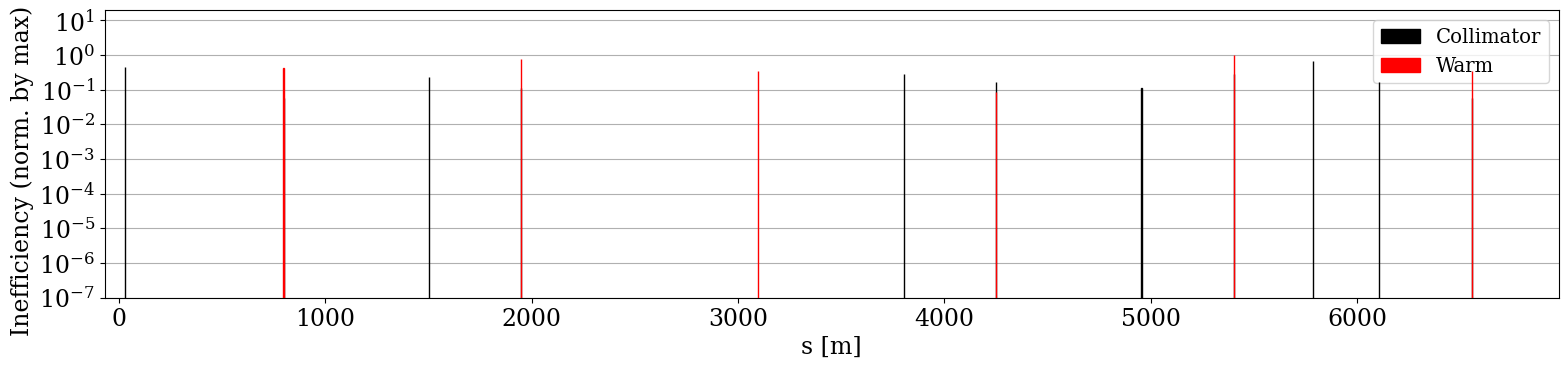

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Inefficiency (norm. by max) [-]'>)

In [286]:
ThisLM.plot(savefig='flanges_test_air.pdf', norm='max')

In [287]:
loc, nn = np.unique(part.at_element, return_counts=True)
for ii, nnn in zip(loc, nn):
    print(f'{line.element_names[ii]}: {nnn} particles lost') 

vcak.10101_coll_2..0: 2 particles lost
vcak.12501.a_aper: 10 particles lost
vcak.12501_coll_2..0: 1 particles lost
vcak.21101_coll_2..0: 4 particles lost
vcak.22501.a_aper: 18 particles lost
vcak.22501_coll_2..0: 2 particles lost
vcak.32501.a_aper: 8 particles lost
vcak.41101_coll_2..0: 5 particles lost
vcak.42501.a_aper: 2 particles lost
vcak.42501_coll_2..0: 3 particles lost
vcak.51101_coll_2..0: 2 particles lost
vcak.52501.a_aper: 23 particles lost
vcak.52501_coll_2..0: 5 particles lost
vcak.60101_coll_2..0: 3 particles lost
vcak.61101_coll_2..0: 3 particles lost
vcak.62501.a_aper: 8 particles lost
vcak.62501_coll_2..0: 1 particles lost


In [293]:
tt = line.get_table()
tt.rows['qf.12610<<300':'qf.12610>>40'].show()

name                              s element_type           isthick isreplica parent_name        ...
mba.12430..entry_map         771.39 ThinSliceRBendEntry      False     False mba.12430         
mba.12430..0_aper2           771.39 LimitRect                False     False None              
mba.12430..0                 771.39 ThickSliceRBend           True     False mba.12430         
mba.12430..1_aper2          772.016 LimitRect                False     False None              
mba.12430..1                772.016 ThickSliceRBend           True     False mba.12430         
mba.12430..2_aper2          772.642 LimitRect                False     False None              
mba.12430..2                772.642 ThickSliceRBend           True     False mba.12430         
mba.12430..3_aper2          773.268 LimitRect                False     False None              
mba.12430..3                773.268 ThickSliceRBend           True     False mba.12430         
mba.12430..4_aper2          773.894 

In [294]:
tta = line.get_aperture_table()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [303]:
tta.rows['lsd.*._aper'].show()

name                         s    x_aper_low   x_aper_high x_aper_low_discrete ...
lsd.22305.a_aper             0       -0.0205        0.0205             -0.0205
lsd.22305.b_aper             0       -0.0205        0.0205             -0.0205
lsd.22505.a_aper             0       -0.0205        0.0205             -0.0205
lsd.22505.b_aper             0       -0.0205        0.0205             -0.0205
lsd.22705.a_aper             0       -0.0205        0.0205             -0.0205
lsd.22705.b_aper             0       -0.0205        0.0205             -0.0205
lsd.23505.a_aper             0       -0.0205        0.0205             -0.0205
lsd.23505.b_aper             0       -0.0205        0.0205             -0.0205
lsd.30305.a_aper             0       -0.0205        0.0205             -0.0205
lsd.30305.b_aper             0       -0.0205        0.0205             -0.0205
lsd.31305.a_aper             0       -0.0205        0.0205             -0.0205
lsd.31305.b_aper             0       -0.0205    

In [298]:
line['lsf.63605.b_aper']

View of LimitEllipse(a=0.076, b=0.0192)

In [299]:
line['lsf.11405.b_aper']

View of LimitEllipse(a=0.076, b=0.0192)

In [300]:
76*2

152

In [304]:
line['lsd.22305.a_aper']

View of LimitEllipse(a=0.0415, b=0.0415)

L1 + L2 is beter (1 pijp) (zien voor verdeling)

Aperture marker moet weg aan het einde van mbb

qd thin slicen en glidcop ertussen steken
lsd ook

verwijder alle aperture markers ertussen, laatste van mbbook, en dan enkel qd aperture aan het einde houden

Spelen met air/beryllium


In [306]:
len(line.collimators)*3

318

Wss losses op laatste qd aperture komen, omdat slechte normalisatie